# Pytorch Basics

Pytorch is a library that supports automatic differentiation based on a system that can generate computational graphs.

In the first part, we'll check an example where we try to fit a linear function onto a set of data points.

## Tensors

Very much like the array in Numpy, the core class in pytorch is tensor, almost all operations are done with tensors, the interfaces and logics of tensor is almost identical to numpy array, you can define, calculate them in the same way.

In [1]:
import torch

print(f'Random noise tensor: \n{torch.randn(3,3)}\n')
print(f'Arithmetic progression tensor: \n{torch.arange(0,2, 0.3)}\n')
print(f'Diagonal tensor: \n{torch.diag(torch.tensor([1,2,3]))}')

Random noise tensor: 
tensor([[-0.3832,  1.5449,  0.4372],
        [ 1.0938, -0.6512, -0.5688],
        [-0.4532,  1.4161,  1.0082]])

Arithmetic progression tensor: 
tensor([0.0000, 0.3000, 0.6000, 0.9000, 1.2000, 1.5000, 1.8000])

Diagonal tensor: 
tensor([[1, 0, 0],
        [0, 2, 0],
        [0, 0, 3]])


First off, let's generate some synthetic data. Assuming our probabilistic model here is $y = \alpha * x + \beta + \epsilon$, where $\epsilon$ is random noise from a normal distribution. Let's sample some data from this model and illustrate them.

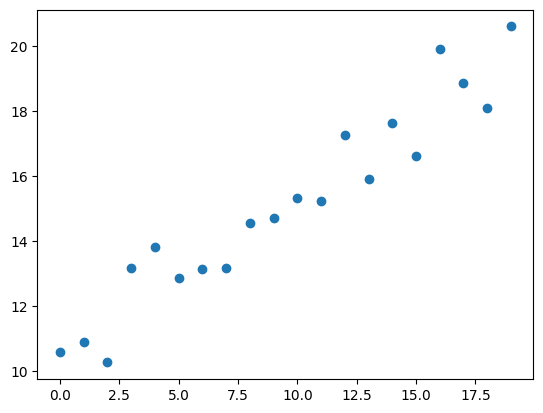

In [85]:
import torch
import matplotlib.pyplot as plt

alpha = 0.5
beta = 10
gamma = 0.8

x = torch.arange(0,20).to(torch.float32)

y = alpha * x + beta + gamma * torch.randn_like(x)

plt.scatter(x, y)

Now we want to estimate the real $\alpha$ and $\beta$ given the data. Let's define them first,

In [86]:
alpha_est = torch.tensor([0.], requires_grad=True)
beta_est = torch.tensor([0.], requires_grad=True)

iter = 0
alpha_values = [alpha_est.detach().item()]
beta_values = [beta_est.detach().item()]
delta_values = []

The reason I set `requires_grad` to true is that these are the parameters we want to receive gradients and adjust according to how well they fit the dataset.

Thus the first thing we need to do is to define "how well they fit the dataset", which is pretty straightforward, we define the distance as $\Delta = | y - \hat{y}|$, where $\hat{y}$ is the sample data, and $y = \alpha \hat{x} + \beta$, $\alpha$ and $\beta$ are `alpha_est` and `beta_est` respectively. By differentiating $\Delta$ with respect to $\alpha$ and $\beta$, we can get the gradients on $\alpha$ and $\beta$ and see how they should adjust to fit the data better.

Here's how we should do all of this for once.

In [87]:
import torch.optim as optim
optimizor = optim.SGD([alpha_est, beta_est], lr=0.001)

delta_before = ((alpha_est * x + beta_est - y).abs()).sum()
delta_values.append(delta_before.detach().item())
print(f'Delta before: {delta_before}, grad on alpha: {alpha_est.grad}, grad on beta: {beta_est.grad}')
print(f'alpha before: {alpha_est}, beta before: {beta_est}')
delta_before.backward()
print(f'grad on alpha: {alpha_est.grad}, grad on beta: {beta_est.grad}')
optimizor.step()
delta_after = ((alpha_est * x + beta_est - y).abs()).sum()
print(f'Delta after: {delta_after}')
print(f'alpha after: {alpha_est}, beta after: {beta_est}')

iter += 1
alpha_values.append(alpha_est.detach().item())
beta_values.append(beta_est.detach().item())
delta_values.append(delta_after.detach().item())

Delta before: 302.53094482421875, grad on alpha: None, grad on beta: None
alpha before: tensor([0.], requires_grad=True), beta before: tensor([0.], requires_grad=True)
grad on alpha: tensor([-190.]), grad on beta: tensor([-20.])
Delta after: 266.0309143066406
alpha after: tensor([0.1900], requires_grad=True), beta after: tensor([0.0200], requires_grad=True)


Let's check what the optimizor did

In [88]:
alpha_est + 0.001 * alpha_est.grad

tensor([0.], grad_fn=<AddBackward0>)

Let's do this for many times to see how the `alpha_est` and `beta_est` change

In [89]:
optimizor = optim.SGD([alpha_est, beta_est], lr=0.001)

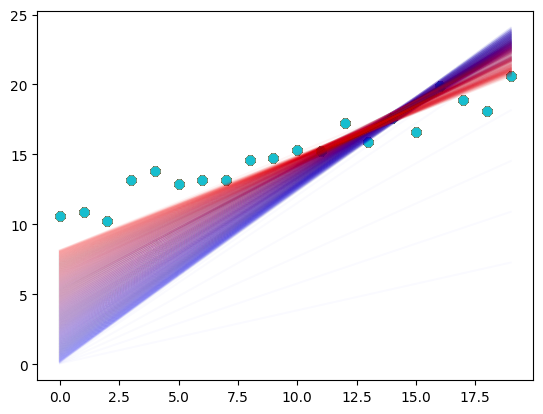

In [90]:
ITER = 1000
def iter_color(i, ITER):
    return (i / ITER, 0, 1 - i / ITER, 0.02)
for i in range(ITER):
    delta = ((alpha_est * x + beta_est - y).abs()).sum()
    optimizor.zero_grad()
    delta.backward()
    optimizor.step()
    with torch.no_grad():
        plt.scatter(x, y)
        y_est = alpha_est * x + beta_est
        plt.plot(x, y_est, color=iter_color(i, ITER))
        iter += 1
        alpha_values.append(alpha_est.detach().item())
        beta_values.append(beta_est.detach().item())
        delta_values.append(delta.detach().item())


In [91]:
print(f'alpha: {alpha_est}, beta: {beta_est}')

alpha: tensor([0.6540], requires_grad=True), beta: tensor([8.1460], requires_grad=True)


Let's also plot how the parameters and delta change over the iteration

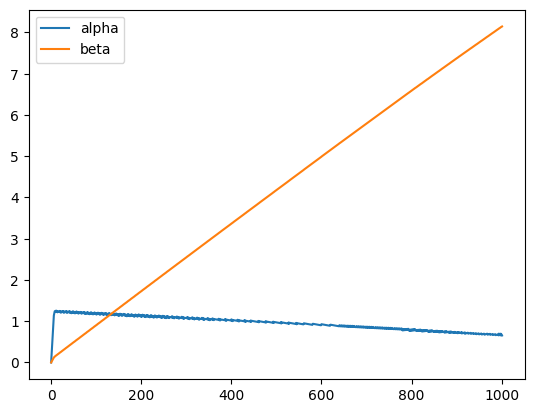

In [92]:
import numpy as np
plt.plot(np.arange(len(alpha_values)), np.array(alpha_values), label='alpha')
plt.plot(np.arange(len(beta_values)), np.array(beta_values), label='beta')
plt.legend()
plt.show()

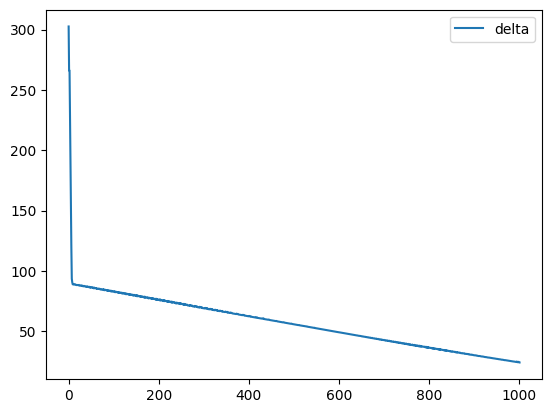

In [94]:
plt.plot(np.arange(len(delta_values)), np.array(delta_values), label='delta')
plt.legend()
plt.show()

# Pytorch Dataset
Now that we understood how the pytorch basically works including the data part, the differentiation part, we can crank up each part respectively to the real world situation. In today's tutorial, we'll only introduce the data part, and in the next one, we'll get to the complete training pipeline of a neural network. Because the operations in torch require some specific data formats, it'll be a lot easier to learn the actual network operations if we have datasets in our hand.

When we installed pytorch, we installed another library along with it, called torchvision (you don't need to install it on colab, as torchvision is built-in), this is a library that stores the information needed to harness some very popular and common datasets that we use a lot, like CIFAR and MNIST, we will show how to utilize it to provide the data in the way that we want.

Like always, we need to import first.

In [95]:
import torchvision

Let's try the MNIST dataset first, which is a dataset contains thousands of hand written number images

In [96]:
mnist_train = torchvision.datasets.MNIST("MNIST", train=True, transform=None, target_transform=None, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



- the first argument `"MNIST"` points out the folder where the dataset will be stored
- `train=True` indicates that this will be the training set
- `transfrom`/`target_transform` are the functions to modify the input data and the ground truth labels (target) in case you are not satisfied with the current form of data (for example, you want extra white bezels around images
- `download=True` tells the function to download the dataset if it can't find the existing dataset in the indicated folder

this `mnist_train` is an iterable item, which means that if you do
```python
for item in mnist_train:
    print(item)
```
you will iterate over all the items stored inside the object.
**More importantly, all datasets comply with a certain protocol such that they all support `__getitem__` method,**
which means that we can easily access these data by using index!
Let's pick out one.

In [97]:
example_datum = mnist_train[0]
print(example_datum)

(<PIL.Image.Image image mode=L size=28x28 at 0x7F60CD2E69D0>, 5)


You can see that each datum is a tuple made up from an image and a label.

You don't need to understand what this `PIL.Image.Image` class is, all you need to know is that it can be translated to numpy with `numpy.array`, just call it upon the image.

Let's transform the image to the (H x W x C) numpy arrays that we are familiar with.

In [98]:
raw_image = example_datum[0]
example_image = np.array(raw_image)
print(example_image.shape)

(28, 28)


And we see that this is an image of size 28x28.

Here's the thing, we don't want to do this numpy transform every thing we pick out a piece of data, which would be tedious and forgettable. Luckily, we have that transform utility that this dataset provides to us. if we supply the `transform` with a function that takes in a piece of data and returns the processed data, this function will be called upon all data that comes out of it.

Note: `transform` is to transform the training data, i.e. images, `target_transform` is to transform the target, in other words, ground truth labels

In [100]:
def image_to_numpy(image):
    return np.array(image)

def number_to_word(number):
    num_dict = {
        1: 'One',
        2: 'Two',
        3: 'Three',
        4: 'Four',
        5: 'Five',
        6: 'Six',
        7: 'Seven',
        8: 'Eight',
        9: 'Nine'
    }
    return num_dict[number]

mnist_train = torchvision.datasets.MNIST("MNIST", train=True,
        transform=image_to_numpy,
        target_transform=number_to_word, download=True)

let's recheck the results:

In [101]:
example_datum = mnist_train[0]
print(example_datum)

(array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [ 

This is only to demonstrate `target_transform`, don't transform numbers to strings, strings are always bad for computing!

Not only that, we can also access the number of data inside this dataset using the method `len`, just like we do to a list

In [102]:
print(f'The number of data in this mnist dataset is {len(mnist_train)}')

The number of data in this mnist dataset is 60000


Let's visualize one of them!

**notice**: this image is **NOT** a 3-channel color image like jpeg/png, it's a grayscale image.

(-0.5, 27.5, 27.5, -0.5)

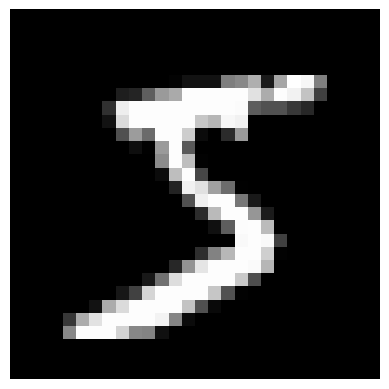

In [103]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(example_image, cmap='gray')
plt.axis('off')

We can do the exact same thing with CIFAR dataset.

Download and prep them first

In [104]:
cifar10_train = torchvision.datasets.CIFAR10("CIFAR10", train=True, transform=None,
                                           target_transform=None, download=True)

example_datum = cifar10_train[0]
print(f'print example datum: {example_datum}')

raw_image = example_datum[0]
example_image = np.array(raw_image)
print(f'image dimensions: {example_image.shape}')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting CIFAR10/cifar-10-python.tar.gz to CIFAR10
print example datum: (<PIL.Image.Image image mode=RGB size=32x32 at 0x7F60CD827AF0>, 6)
image dimensions: (32, 32, 3)


Visualize an example image

(-0.5, 31.5, 31.5, -0.5)

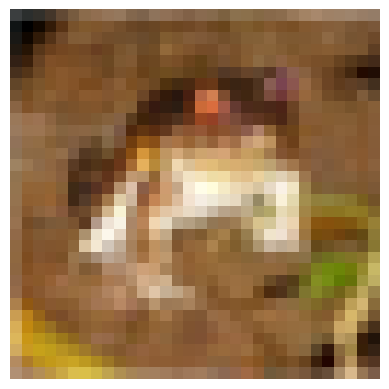

In [105]:
plt.imshow(example_image)
plt.axis('off')

#### 1.2 Using data loader to iterate data in a way we specified

Right now you can think of these datasets as lists, because they behave quite like lists, they have indexing and length, but if we put this list into a `for` loop,
```python
for item in cifar10_train:
    print(item)
```
we can only iterate over these data by order, and sometimes we just want these data fed in another way, say, randomly iterated, or in a batched form. It won't be hard to create another function to do this, but pytorch has already done it for us.

The tool that is going to help us prepare data in our specified ways is called `DataLoader`, let's make a dataloader out of our datasets.

In [106]:
mnist_train = torchvision.datasets.MNIST("MNIST", train=True, transform=image_to_numpy,
                                         target_transform=None, download=True)
from torch.utils.data import DataLoader
mnist_train_dataloader = DataLoader(mnist_train, batch_size=4, shuffle=True)

Now let's take out the first batch of data from this dataloader, because it is an iterable item, we use the `next`, `iter` way to get the first one out.

In [107]:
first_batch = next(mnist_train_dataloader.__iter__())
print(f'the type of this object is {type(first_batch)}')
print(f'the length of this tuple is {len(first_batch)}')
print(f'the type of the first item in the tuple is {type(first_batch[0])}')
print(f'the shape of the first item is {first_batch[0].shape}')
print(f'the last item in the tuple is {first_batch[1]}')

the type of this object is <class 'list'>
the length of this tuple is 2
the type of the first item in the tuple is <class 'torch.Tensor'>
the shape of the first item is torch.Size([4, 28, 28])
the last item in the tuple is tensor([9, 8, 9, 6])


Note: from dataloader, all items including images and labels have been transformed to `torch.Tensor`.

Next time, we'll make a dataset from our own data.